#  Analysis of Consumer Reviews of Amazon Products Using Large Language Model

## Installing Modules

In [1]:
from transformers import pipeline
from transformers import TrainingArguments, Trainer

In [2]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.1 MB/s eta 0:00:00


In [3]:
!pip install Emoticon

  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of emoticon to determine which version is compatible with other requirements. This could take a while.
  Created wheel for mtranslate: filename=mtranslate-1.8-py3-none-any.whl size=3672 sha256=5fa03349cd6a72c91b5860796f1b82822d69cdd3f3fdd109a18605be05252d03
  Stored in directory: /root/.cache/pip/wheels/c2/04/15/d7654c2c4a9a52e09922967593f3278fed66059be65ca671ea
Successfully built mtranslate


In [4]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import seaborn as sns
import pandas as pd
pd.options.display.max_colwidth = 300
from sklearn.utils import class_weight
import numpy as np
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
from transformers import AutoModelForSequenceClassification
from datasets import Dataset
from datasets import load_metric
from Emoticon import EMOTICONS_EMO
from sklearn.utils import shuffle
import torch
from torch import nn
from transformers import DataCollatorWithPadding

### Data Description

For this project we used the data provided by Kaggle [Consumer Reviews of Amazon Products]. The dataset includes rating, review text, category, timestamp etc. for each product.



## Helper Functions

In [5]:
def create_sentiment(row):
    """ Convert rating to setiment
    Input:
        pandas Series row
    Output
        pandas Series row


    """
    if row >= 4:
        sentiment = 1
    else:
        sentiment = 0
    return sentiment

In [6]:
def convert_predictions(row):
    """ Convert predicted sentiment to nummeric output
    Input:
        pandas Series row
    Output
        pandas Series row


    """
    if row[0]["label"]=='POSITIVE':
        sentiment = 1
    elif row[0]["label"]=='NEGATIVE':
        sentiment = 0
    else:
        sentiment = np.nan
    return sentiment

## 1. Data Wrangling

In [7]:
df =  pd.read_csv('Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products (1).csv',low_memory=False)

In [8]:
df.head(3)

,id,dateAdded,dateUpdated,name,asins,brand,categories,primaryCategories,imageURLs,keys,...,reviews.dateSeen,reviews.doRecommend,reviews.id,reviews.numHelpful,reviews.rating,reviews.sourceURLs,reviews.text,reviews.title,reviews.username,sourceURLs
0,AVqVGZNvQMlgsOJE6eUY,2017-03-03T16:56:05Z,2018-10-25T16:36:31Z,"Amazon Kindle E-Reader 6"" Wifi (8th Generation, 2016)",B00ZV9PXP2,Amazon,"Computers,Electronics Features,Tablets,Electronics,iPad & Tablets,Kindle E-readers,iPad Accessories,Used:Tablets,E-Readers,E-Readers & Accessories,Computers/Tablets & Networking,Used:Computers Accessories,iPads Tablets,All Tablets,Tablets & E-readers,Computers & Tablets,Amazon,Tablets & eBook Re...",Electronics,"https://pisces.bbystatic.com/image2/BestBuy_US/images/products/5442/5442403_sd.jpg,https://c1.neweggimages.com/NeweggImage/ProductImage/A3FA_1_201801081360871160.jpg,https://i.ebayimg.com/thumbs/images/g/N4IAAOSwoA9Zgkso/s-l96.jpg,http://i.ebayimg.com/thumbs/images/g/dpkAAOSwfpVZFKHy/s-l200.jpg,...","allnewkindleereaderblack6glarefreetouchscreendisplaywifiincludesspecialoffers/b00zv9pxp2,allnewkindleereaderblack6glarefreetouchscreendisplaywifiincludesspecialoffers/9siafvd7fk6707,0848719083774,848719083774,allnewkindleereaderblack6glarefreetouchscreendisplaywifiincludesspecialoffers/322538285...",...,"2018-05-27T00:00:00Z,2017-09-18T00:00:00Z,2017-09-06T00:00:00Z,2017-09-12T00:00:00Z",False,NaN,0,3,"http://reviews.bestbuy.com/3545/5442403/reviews.htm%25252525253Fformat%25252525253Dembedded,https://reviews.bestbuy.com/3545/5442403/reviews.htm%2525252525253Fformat%2525252525253Dembedded%25252525252526page%2525252525253D20,https://reviews.bestbuy.com/3545/5442403/reviews.htm%25252525253Fformat...",I thought it would be as big as small paper but turn out to be just like my palm. I think it is too small to read on it... not very comfortable as regular Kindle. Would definitely recommend a paperwhite instead.,Too small,llyyue,"https://www.newegg.com/Product/Product.aspx%25253FItem%25253D9SIAFVD7FK6707,https://reviews.bestbuy.com/3545/5442403/reviews.htm%2525252525253Fformat%2525252525253Dembedded%25252525252526page%2525252525253D39,https://reviews.bestbuy.com/3545/5442403/reviews.htm%2525252525253Fformat%2525252525253..."
1,AVqVGZNvQMlgsOJE6eUY,2017-03-03T16:56:05Z,2018-10-25T16:36:31Z,"Amazon Kindle E-Reader 6"" Wifi (8th Generation, 2016)",B00ZV9PXP2,Amazon,"Computers,Electronics Features,Tablets,Electronics,iPad & Tablets,Kindle E-readers,iPad Accessories,Used:Tablets,E-Readers,E-Readers & Accessories,Computers/Tablets & Networking,Used:Computers Accessories,iPads Tablets,All Tablets,Tablets & E-readers,Computers & Tablets,Amazon,Tablets & eBook Re...",Electronics,"https://pisces.bbystatic.com/image2/BestBuy_US/images/products/5442/5442403_sd.jpg,https://c1.neweggimages.com/NeweggImage/ProductImage/A3FA_1_201801081360871160.jpg,https://i.ebayimg.com/thumbs/images/g/N4IAAOSwoA9Zgkso/s-l96.jpg,http://i.ebayimg.com/thumbs/images/g/dpkAAOSwfpVZFKHy/s-l200.jpg,...","allnewkindleereaderblack6glarefreetouchscreendisplaywifiincludesspecialoffers/b00zv9pxp2,allnewkindleereaderblack6glarefreetouchscreendisplaywifiincludesspecialoffers/9siafvd7fk6707,0848719083774,848719083774,allnewkindleereaderblack6glarefreetouchscreendisplaywifiincludesspecialoffers/322538285...",...,"2018-05-27T00:00:00Z,2017-07-07T00:00:00Z,2017-08-09T00:00:00Z,2017-08-02T00:00:00Z,2017-08-31T00:00:00Z",True,NaN,0,5,"http://reviews.bestbuy.com/3545/5442403/reviews.htm%25252525253Fformat%25252525253Dembedded%252525252526page%25252525253D2,http://reviews.bestbuy.com/3545/5442403/reviews.htm%25252525253Fformat%25252525253Dembedded%252525252526page%25252525253D4,https://reviews.bestbuy.com/3545/5442403/reviews.h...",This kindle is light and easy to use especially at the beach!!!,Great light reader. Easy to use at the beach,Charmi,"https://www.newegg.com/Product/Product.aspx%25253FItem%25253D9SIAFVD7FK6707,https://reviews.bestbuy.com/3545/5442403/reviews.htm%2525252525253Fformat%2525252

In [9]:
df.columns

Index(['id', 'dateAdded', 'dateUpdated', 'name', 'asins', 'brand',
       'categories', 'primaryCategories', 'imageURLs', 'keys', 'manufacturer',
       'manufacturerNumber', 'reviews.date', 'reviews.dateAdded',
       'reviews.dateSeen', 'reviews.doRecommend', 'reviews.id',
       'reviews.numHelpful', 'reviews.rating', 'reviews.sourceURLs',
       'reviews.text', 'reviews.title', 'reviews.username', 'sourceURLs'],
      dtype='object')

In [10]:
df['categories'].unique()

array(['Computers,Electronics Features,Tablets,Electronics,iPad & Tablets,Kindle E-readers,iPad Accessories,Used:Tablets,E-Readers,E-Readers & Accessories,Computers/Tablets & Networking,Used:Computers Accessories,iPads Tablets,All Tablets,Tablets & E-readers,Computers & Tablets,Amazon,Tablets & eBook Readers',
       'Computers,Amazon Echo,Virtual Assistant Speakers,Audio & Video Components,Electronics Features,Computer Accessories,Home & Tools,See more Amazon Echo Show Smart Assistant - White,Smart Home Automation,Electronics,TVs Entertainment,Speakers,Smart Hub & Kits,Digital Device 3,Consumer Electronics,Wireless Speakers,Home Improvement,Amazon Home,Amazon,Computer Speakers,Voice-Enabled Smart Assistants',
       'Amazon Echo,Virtual Assistant Speakers,Electronics Features,Home & Tools,Smart Home Automation,TVs Entertainment,Speakers,Smart Hub & Kits,Digital Device 3,Wireless Speakers,Smart Home,Home Improvement,Voice Assistants,Amazon Home,Amazon',
       'Amazon SMP,TV, Video & H

In [11]:
#checking the initial dataset
df.shape

(5000, 24)

We plan to work with t=columns of the reviews.text column ,reviews.title column and reviews.rating column.

In [12]:
# remove empty reviews,title and rating
df = df[(df['reviews.text'].isnull()==False)&(df['reviews.rating'].isnull()==False)&(df['reviews.title'].isnull()==False)]

In [13]:
df.shape

(4987, 24)

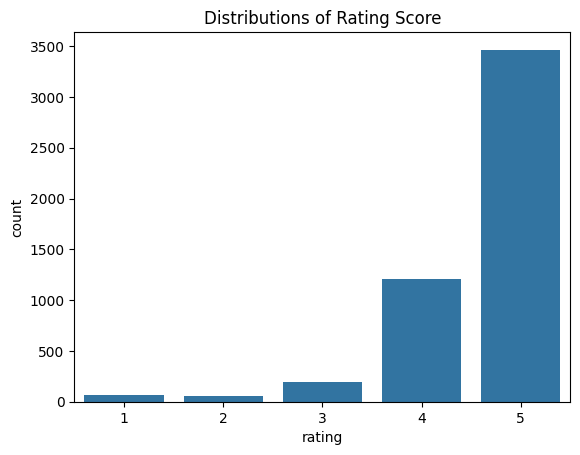

In [14]:
sns.countplot(data=df, x="reviews.rating")
plt.xlabel('rating');
plt.title("Distributions of Rating Score");

Merging the Review title and the review text to together.

In [15]:
df["full_review"] = df["reviews.text"]+" " +df["reviews.title"]

Turning to the graphic, it shows the scores from minimal 1 and maximum 5.
Interesting is that the data has a lot of better score (4-5) and less negative (1-3)

In [16]:
# convert rating to sentiment classes (positive and negative)
df.loc[:,'label'] = df['reviews.rating'].apply(create_sentiment)

In [17]:
df = df[['full_review','label',]]

In [18]:
df.rename(columns={'full_review': "text"},inplace=True)

In [19]:
# remove duplicates
df.drop_duplicates(subset=['text'], keep='last', inplace=True)

In [20]:
df.shape

(4385, 2)

The text in comments is quite clean without html tags and with very few links. So for that reason, I will only convert emojis to text. In addition, for data Data augmentation (Section 3) I will use the technique of back translation. Therefore, I will not lowercase the text.

In [21]:
def convert_emoticons_to_words(row):
    """ Convert emojis in comments into text
    Input:
        pandas Series row
    Output
        pandas Series row


    """
    for i, j in EMOTICONS_EMO.items():
        row = str(row).replace(i, j)
    return row


In [22]:
df['text'] = df['text'].apply(convert_emoticons_to_words)

In [23]:
len(df)

4385

In [24]:
def visualize_class_distribution(data):
    """
    Visualisation of the proportions
    for each class
    Input:
        data: pandas dataframe
    Output:
        None

    """
    colors = ['royalblue', 'pink']
    fig, ax = plt.subplots()
    ax.pie(data['label'].value_counts(), labels=["positive","negative"], autopct='%1.1f%%', colors=colors)
    plt.title("Sentiment Class Distribution");


The graph below makes it clear that the class of negative reviews is disproportionally underrepresented. This challenge will be handled in the section "3. Data augmentation" and "5. Data balancing"

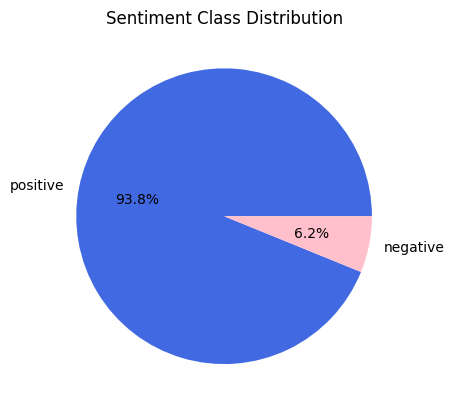

In [25]:
visualize_class_distribution(df)

## 2. Data splitting

In [26]:
# splitting dataset into training(60%), validation(20%) and test set (20%)
train, validate, test = \
              np.split(df.sample(frac=1, random_state=42),
                       [int(.6*len(df)), int(.8*len(df))])

## Using Basic "sentiment-roberta-large-english" Model

As the baseline I use [SiEBERT - English-Language Sentiment Classification](https://huggingface.co/siebert/sentiment-roberta-large-english) model which enables to predict positive and negative sentiment. The model is a fine-tuned checkpoint of RoBERTa-large (Liu et al. 2019) and outperformed DistilBERT SST-2
on average by  15 p.p. (78.1 vs 93.2)


In [27]:
roberta_classifier = pipeline("sentiment-analysis",model="siebert/sentiment-roberta-large-english",truncation = True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/687 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/256 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

In [28]:
def get_predictions(data_test, classifier):
    """
    Create new column with predictions
    Input:
        data_test: DataFrame
    Output:
        data_test: DataFrame (with predictions)
    """
    data_test['roberta_sentiment'] = data_test['text'].apply(lambda x : classifier(x))
    data_test.loc[:,'predicted'] =data_test["roberta_sentiment"].apply(convert_predictions)
    return data_test

In [29]:
test_basis = test.copy()

In [30]:
test_basis

,text,label
4135,"This is actually a pretty good little tablet. It is not the most powerful and it doesn't have the highest resolution screen. But for the price, you can't go wrong. It does what it is supposed to do and for the low price you won't feel much pain if you break it. A perfect first tablet for the kid...",1
4848,Ok so in order to get three working well I needed to get four but the one that needed to be returned was quite easy. All is great! Kids love them! Great inexpensive tablet,1
3598,"I bought two of these Fire Tablets for gifts for my sons. They are both thrilled with the features. They use them for gaming, music, photo albums, emails and online activities. The HD is what sold me. I have a Kindle Fire 2nd generation and I enjoyed mine so much since 2012, I looked into gettin...",1
4415,Moved all the ad apps to a folder and loaded what I wanted. Small size fits in my sport coat pocket. Good for the price,1
94,I should have purchased a kindle sooner. It's easy to use and I love it! Great kindle for the price.,1
...,...,...
3920,Purchased for 4 yr old granddaughter who primarily uses for Netflix. Works great! Good tablet,1
570,We are enjoying our amazon echo show. Alexa is so amazing answering questions and a variety of music!!!! Alexa is awesome,1
3568,Only problem is that it is impossible to read or do anything on the KindleFire with any light in the room at all; far worse than impossible in sunlight. There should be some sort of temporary screen or other add-on that can be used with the device when in sunny or bright locations. Excellent tab...,1
4255,"This tablet does a great deal! From surfing the net, to watching movie, and using all of the music channels, this is an affordable way to stay in touch. Also, I use it for ebooks for school. Does a lot",1


In [31]:
test_basis_prediction = get_predictions(test_basis, roberta_classifier)

In [ ]:
classification_report(test_basis_prediction.label, test_basis_prediction.predicted)

In [34]:
# check if there are any unpredicted comments
test_basis_prediction[test_basis_prediction.predicted.isnull()==True]

,text,label,roberta_sentiment,predicted


## Fine-tuning model

## 3. Data augmentation

For data augmentation I will use the technique [“Back Translation”](https://towardsdatascience.com/nlp-data-augmentation-using-transformers-89a44a993bab).  First of all, I translate the English text into German and then back to English. The major reasons for this technique are
1.	There are enough good performing models for English
2.	Due to the fact, that the task is sentiment analysis (the polarity of the sentences). I don’t want to add noise to the dataset with random replacement, random insertion or text generation etc.
3. With Back Translation we will create new samples for the minority class (oversampling)


In [35]:
#English to German
translation_en_to_de = pipeline("translation_en_to_de", model='t5-base')

#Germal to English
tokenizer = AutoTokenizer.from_pretrained("google/bert2bert_L-24_wmt_de_en", pad_token="<pad>", eos_token="</s>", bos_token="<s>")
model_de_to_en = AutoModelForSeq2SeqLM.from_pretrained("google/bert2bert_L-24_wmt_de_en")


config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/892M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/3.44k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/269k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/3.09G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/207 [00:00<?, ?B/s]

In [36]:
def back_translation(input_text):
    """ Translate the text from English to German
        and then from German to English
    Input:
        pandas Series row
    Output
        pandas Series row


    """
    review_en_to_de = translation_en_to_de(input_text)
    text_en_to_de = review_en_to_de[0]['translation_text']
    input_ids = tokenizer(text_en_to_de, return_tensors="pt", add_special_tokens=False,max_length=512,truncation=True).input_ids
    output_ids = model_de_to_en.generate(input_ids)[0]
    augmented_review = tokenizer.decode(output_ids, skip_special_tokens=True)
    return augmented_review

In [37]:
def create_data_samples(data):
    """
    Create new samples for training
    Input:
        data: pandas data frame
    Output:
        data: pandas data frame with additional sampels

    """
    count_labels= data["label"].value_counts()
    n = count_labels[1]-count_labels[0]
    #oversampling for negative class
    data_temp = data[data.label==0].sample(n=n, replace=True, random_state=42)

    data_temp.loc[:,'samples'] =data_temp["text"].apply(back_translation)
    data_temp = data_temp.drop('text', axis=1)
    data_temp.rename(columns={'samples': "text"},inplace=True)
    data_sampled = pd.concat([data_temp, data], ignore_index=True)
    data_sampled = shuffle(data_sampled, random_state=0)
    return data_sampled


In [ ]:
train.shape


(2631, 2)

In [ ]:
train.head()

,text,label
804,"I‚Äôm all about the smart home and I love my new echo show. I stay more connected with my family. I also love how it‚Äôs integrated with my Arlo, Ring, Nest, and Hue light bulbs. Must have new fun technology",1
2854,I'll give it 3 starts because it's a decent tablet. But if the screen messes up when I'm trying to use it i can't imagine how my granddaughter feels. Not as good as I'd hoped,0
726,It's great! I love the hand free whatever you want. It plays videos on Amazon by just asking it to play. At work I can video call my girlfriend at home with the show as well. Highly recommend Great product.. best home speaker out there!!!,1
3085,"This is fun but would not buy again. Not very informative. Keeps say ""I do not understand your question. "" A little fun but not very useful",0
1532,Alexa rocks. The Echo Plus is super easy to set up. I works great. Love everything about it. Adding more devices. Echo Plus is fantastic,1


In [38]:
train1 = create_data_samples(train[:100])

In [39]:
train1

,label,text
94,1,Perfect cheap device for kids and grandkids nice to have sitting around Perfect
18,0,"tablet that I take for my child to play while eating, keep contact with him."
33,0,I hope they make improvements that allow you to dimmy the screen more and I am not printed to connect a camera on my nachttich to the internet.
98,1,"I previously owned a Nucleus device which was similar to this device but was not a great device and had a lot of bugs and did not do much so I returned it. This device is a masterpiece! Not only is it tied into the Alexa Echo universe, it can be used as an intercom throughout your house with oth..."
181,1,everything was as I expected.... and order it online and pick it up next day... easy to do... good
...,...,...
103,1,Alexa Exceed expectations in it ability to control Great Experience exceeds expectaton
67,0,"tablet that I take for my child to play while eating, keep contact with him."
117,1,"Got this for my grandson 7 yrs old - perfect size. Amazon Fire - Great 7"" Tablet"
47,0,"tablet that I take for my child to play while eating, keep contact with him."


Looking at the graph below you can see, that now the training dataset is balanced. This dataset will be used for the second approach (Data Balancing - Oversampling)  

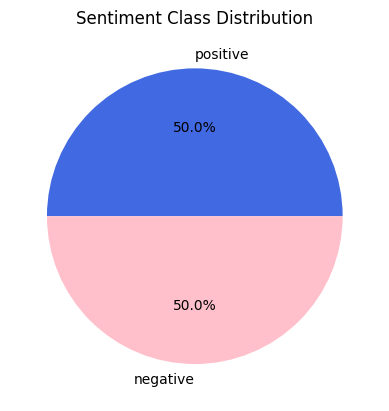

In [40]:
visualize_class_distribution(train1)

## 4. Data preprocessing

One of the parameter of tokenizer is max_length. So, before I use default number, let us check, what is the max number of the reviews


In [41]:
tokenizer = AutoTokenizer.from_pretrained("siebert/sentiment-roberta-large-english")

In [42]:
train = Dataset.from_pandas(train).remove_columns(['__index_level_0__'])
validate = Dataset.from_pandas(validate).remove_columns(['__index_level_0__'])
test = Dataset.from_pandas(test).remove_columns(['__index_level_0__'])

In [43]:
def get_review_len(data):
    """
    Calculate the length of each sentence
    Input:
        data: Dataset
    Output:
        tokens_len: list with length of each sentence

    """
    tokens_len = []
    for review in data["text"]:
        tokens = tokenizer.encode(review)
        tokens_len.append(len(tokens))
    return tokens_len

In [44]:
# max number of tokens
np.array(get_review_len(train)).max()

Token indices sequence length is longer than the specified maximum sequence length for this model (540 > 512). Running this sequence through the model will result in indexing errors


712

In [45]:
# min number of tokens
np.array(get_review_len(train)).min()

8

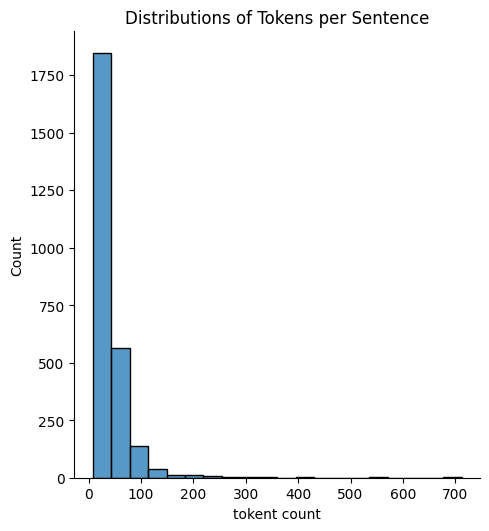

In [46]:
sns.displot(get_review_len(train),bins=20)
plt.xlabel('tokent count');
plt.title("Distributions of Tokens per Sentence");


The graph above makes it clear that the most of the review are below 180 tokens. For that reason, I will set max_lenght to 180

In [47]:
def preprocess_function(data):
    """
    Input data: Dataset
    Output: data: Dataset: with 'input_ids' and 'attention_mask'

    """
    return tokenizer(data['text'], padding="max_length", max_length=180,truncation=True)

In [48]:
tokenized_train = train.map(preprocess_function, batched=True)
tokenized_val= validate.map(preprocess_function, batched=True)

Map:   0%|          | 0/2631 [00:00<?, ? examples/s]

Map:   0%|          | 0/877 [00:00<?, ? examples/s]

In [49]:
#In order to speed up the training, the training samples will be converted to Pytorch tensors
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [50]:
model = AutoModelForSequenceClassification.from_pretrained("siebert/sentiment-roberta-large-english", num_labels=2)

For the evaluation of the model performance, I will use on the one hand, accuracy, on the other hand f1 score (as we have an imbalanced dataset). In comparison to accuracy, the f1-score pays more attention to false negative and false positive predictions

In [51]:
def compute_metrics(eval_pred):
    """
    Defines the evaluation metrics for fine-tuned model

    """
    load_accuracy = load_metric("accuracy")
    load_f1 = load_metric("f1")

    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    accuracy = load_accuracy.compute(predictions=predictions, references=labels)["accuracy"]
    f1 = load_f1.compute(predictions=predictions, references=labels)["f1"]

    print("eval_pred", type(eval_pred))
    print("accuracy", type(accuracy),accuracy)
    print("f1", type(f1),f1)
    return {"accuracy": accuracy, "f1": f1}


In [ ]:
trainer = CustomTrainer(
   model=model,
   args=training_args,
   train_dataset=tokenized_train,
   eval_dataset=tokenized_val,
   tokenizer=tokenizer,
   data_collator=data_collator,
   compute_metrics=compute_metrics
)

In [ ]:
test_fine_tuned_prediction = get_predictions(test_basis, sentiment_model_fine_tuned)

## Summary

1. Result of the Baseline model

              precision    recall  f1-score   support

           0       0.63      0.61      0.62        59
           1       0.97      0.97      0.97       818

    accuracy                           0.95       877
   macro avg       0.80      0.79      0.80       877
weighted avg       0.95      0.95      0.95       877



2. Random oversampling  the minority of class through Back Translation

                   precision    recall  f1-score   support

           0       0.54      0.49      0.51        45
           1       0.97      0.98      0.97       832

    accuracy                            0.95       877
    macro avg       0.75      0.73      0.74       877
    weighted avg    0.95      0.95      0.95       877





Furthermore, the technique used was to help us to compare the three models namely: oversampling and baseline. In result, we can observe the decrease of the f1-score for negative examples (oversampling) by 0.09 compared to weights estimation and by 0.06 compared to baseline model.  Noticeably, the model has challenges to generalize on the test set and considerable increased the training time.